<a href="https://colab.research.google.com/github/varsha6319/Product_Rec/blob/main/Step_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!pip install pyspark==3.3.0

In [3]:
!pip install xgboost

In [4]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import concat_ws, col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml import Pipeline, PipelineModel
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:

# # Download the RAPIDS Accelerator jar
# !wget https://repo1.maven.org/maven2/com/nvidia/rapids-4-spark_2.12/23.02.0/rapids-4-spark_2.12-23.02.0.jar

# # Download the cuDF jar
# !wget https://repo1.maven.org/maven2/ai/rapids/cudf/23.02.0/cudf-23.02.0-cuda11.jar


In [5]:
spark = SparkSession.builder \
    .appName("RandomForest_GPU") \
    .config("spark.executor.memory", "64g") \
    .config("spark.executor.cores", "16") \
    .config("spark.driver.memory", "64g") \
    .config("spark.ui.port", "4040").getOrCreate()

In [6]:
parquet_path1 = '/content/drive/My Drive/santander-product-recommendation/train_data.parquet'
parquet_path2 = '/content/drive/My Drive/santander-product-recommendation/transformed_intermediate_data_0528.parquet'
parquet_path3 = '/content/drive/My Drive/santander-product-recommendation/transformed_test_data.parquet'
parquet_path4 = '/content/drive/My Drive/santander-product-recommendation/transformed_train_data_for_original_intermediate.parquet'

# Read Parquet files into Spark DataFrames
train_data = spark.read.parquet(parquet_path1)
transformed_intermediate_data_0528 = spark.read.parquet(parquet_path2)
test_data = spark.read.parquet(parquet_path3)
original_intermediate_data_0528 = spark.read.parquet(parquet_path4)


In [7]:
# train_data = train_data.select("customer_code","features","multi_label","label")
transformed_intermediate_data_0528 = transformed_intermediate_data_0528.select("customer_code","features")
test_data = test_data.select("customer_code","features")
original_intermediate_data_0528 = original_intermediate_data_0528.select("customer_code","label")

In [8]:
# Load a pretained model from drive
model_path =  "/content/drive/My Drive/santander-product-recommendation/model/"

trained_model = RandomForestClassificationModel.load(model_path)

In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42,
                            numTrees=50, maxDepth=10, minInstancesPerNode=10,
                            featureSubsetStrategy="sqrt")
train_data1 = train_data.select("customer_code","features","multi_label","label")

trained_model = rf.fit(train_data1)

In [9]:

predictions_0528 = trained_model.transform(transformed_intermediate_data_0528)

predicted_products_0528 = predictions_0528.select("customer_code", "prediction").withColumnRenamed("prediction", "predicted_products_0528")

combined_test_data_predicted_products_0528 = test_data.join(predicted_products_0528, on='customer_code', how='left').cache()

predictions_0628 = trained_model.transform(combined_test_data_predicted_products_0528)

combined_data = predictions_0628.withColumn("new_products", col("prediction") - col("predicted_products_0528")) \
                                  .select("customer_code", "new_products")

In [10]:

product_columns = [
    "savings_account", "guarantees", "current_accounts", "derivada_account", "payroll_account",
    "junior_account", "mas_particular_account", "particular_account", "particular_plus_account",
    "short_term_deposits", "medium_term_deposits", "long_term_deposits", "e_account", "funds",
    "mortgage", "loans", "taxes", "credit_card", "securities", "home_account", "payroll",
    "pensions_nom", "pension_plans", "direct_debit"
]

label_to_products_mapping = {i: product_columns[i] for i in range(len(product_columns))}

# Define a function to map prediction index to product column name
def map_prediction_to_products(prediction_col: str, mapping: dict) -> F.Column:
    mapping_expr = F.expr(
        "CASE " +
        " ".join([
            f"WHEN {prediction_col} = {idx} THEN '{product}' "
            for idx, product in mapping.items()
        ]) +
        " ELSE 'unknown' END"
    )
    return mapping_expr


In [11]:
# mapped_new_products = map_prediction_to_product(combined_data, "new_products")
mapped_new_products = combined_data.withColumn("predicted_product", map_prediction_to_products("new_products", label_to_products_mapping))

In [ ]:
mapped_new_products.show()

In [12]:
submission = mapped_new_products.withColumnRenamed("customer_code", "ncodpers").withColumnRenamed("predicted_product", "added_products") \
                                  .select("ncodpers","added_products")

In [ ]:
submission.show()

In [ ]:
model_path = "/content/drive/My Drive/santander-product-recommendation/model_rf_50_10_10_sqrt/"

trained_model.write().overwrite().save(model_path)

print(f"Model saved successfully at: {model_path}")

In [13]:
# Calculate the total number of transactions
total_transactions = train_data.count()

# Initialize an empty list to store individual DataFrames for each product
product_dfs = []

# Iterate through each product column to calculate sales volume and frequency
for product in product_columns:
    # Calculate sales volume
    sales_volume_col = F.sum(F.col(product)).alias("sales_volume")

    # Calculate sales frequency as the number of non-zero transactions for the product divided by the total transactions
    sales_frequency_col = (F.sum(F.when(F.col(product) > 0, 1).otherwise(0)) / total_transactions).alias("sales_frequency")

    # Select and calculate sales volume and frequency for the current product
    product_df = train_data.agg(
        F.lit(product).alias("product"),
        sales_volume_col,
        sales_frequency_col
    )

    # Append the DataFrame to the list
    product_dfs.append(product_df)

# Union all individual DataFrames into a single DataFrame
popular_df = product_dfs[0]
for product_df in product_dfs[1:]:
    popular_df = popular_df.union(product_df)

# Order by sales frequency
popular_df = popular_df.orderBy(F.desc("sales_frequency"))

# Display the resulting DataFrame
popular_df.show(truncate=False)

+-----------------------+------------+---------------------+
|product                |sales_volume|sales_frequency      |
+-----------------------+------------+---------------------+
|current_accounts       |8371617     |0.6604203911678852   |
|particular_account     |1653873     |0.13047078642059282  |
|direct_debit           |1631612     |0.12871465993657086  |
|e_account              |1052012     |0.08299115649381826  |
|payroll_account        |1029864     |0.08124394435743094  |
|pensions_nom           |756951      |0.05971437483522262  |
|payroll                |697406      |0.05501698695996606  |
|taxes                  |661028      |0.0521471981258728   |
|credit_card            |570696      |0.045021084404356704 |
|particular_plus_account|557128      |0.043950731583943886 |
|long_term_deposits     |554834      |0.0437697624381577   |
|securities             |327786      |0.02585839251119066  |
|funds                  |237271      |0.018717842279788396 |
|mas_particular_account 

In [14]:
# Group sales data by age group and product columns to calculate total sales
sales_by_age_group = train_data.groupBy("age_group").agg(
    *[F.sum(F.col(product)).alias(f"sales_volume_{product}") for product in product_columns]
)

# Calculate total sales for each age group
total_sales_by_age_group = sales_by_age_group.select(
    "age_group",
    sum([F.col(f"sales_volume_{product}") for product in product_columns]).alias("total_sales_age_group")
)

# Calculate percentage of each product's sales within each age group
sales_by_age_group_percentage = sales_by_age_group.join(
    total_sales_by_age_group, "age_group"
).withColumn(
    "sales_percentage",
    F.col("total_sales_age_group") / sum([F.col(f"sales_volume_{product}") for product in product_columns])
).orderBy("age_group")

# Show results
sales_by_age_group_percentage.show(truncate=False)

+-----------+----------------------------+-----------------------+-----------------------------+-----------------------------+----------------------------+---------------------------+-----------------------------------+-------------------------------+------------------------------------+--------------------------------+---------------------------------+-------------------------------+----------------------+------------------+---------------------+------------------+------------------+------------------------+-----------------------+-------------------------+--------------------+-------------------------+--------------------------+-------------------------+---------------------+----------------+
|age_group  |sales_volume_savings_account|sales_volume_guarantees|sales_volume_current_accounts|sales_volume_derivada_account|sales_volume_payroll_account|sales_volume_junior_account|sales_volume_mas_particular_account|sales_volume_particular_account|sales_volume_particular_plus_account|sales_vo

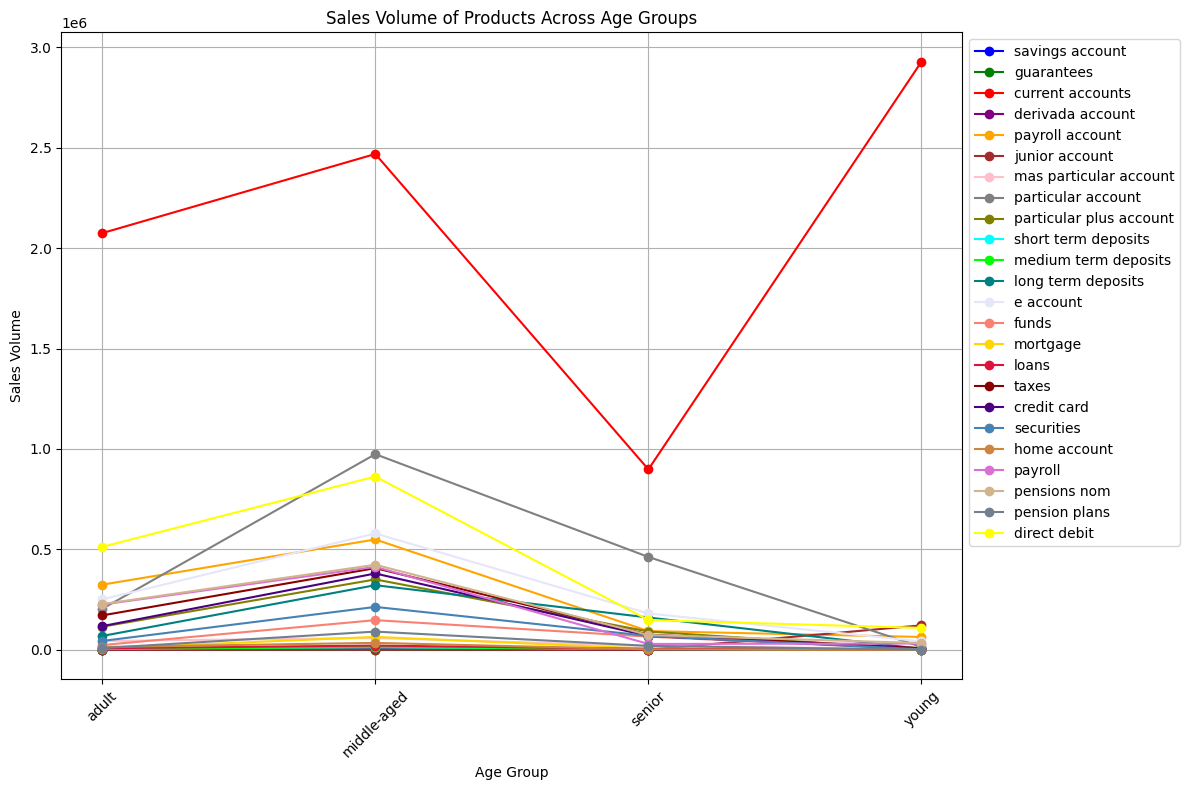

In [15]:


# Convert to Pandas DataFrame for plotting
sales_pd = sales_by_age_group_percentage.toPandas()
# Plotting with Matplotlib
plt.figure(figsize=(12, 8))

# Define colors for each product (adjust as needed)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan',
          'lime', 'teal', 'lavender', 'salmon', 'gold', 'crimson', 'darkred', 'indigo', 'steelblue',
          'peru', 'orchid', 'tan', 'slategray', 'yellow']

# Plot each product's sales across different age groups
for i, product in enumerate(product_columns):
    plt.plot(sales_pd["age_group"], sales_pd[f"sales_volume_{product}"], marker='o', label=product.replace('_', ' '), color=colors[i])

plt.xlabel('Age Group')
plt.ylabel('Sales Volume')
plt.title('Sales Volume of Products Across Age Groups')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Convert to Pandas DataFrame and transpose
vertical_df = popular_df.toPandas().transpose()

# Print the transposed DataFrame
print(vertical_df)

                               0                   1             2   \
product          current_accounts  particular_account  direct_debit   
sales_volume              8371617             1653873       1631612   
sales_frequency           0.66042            0.130471      0.128715   

                        3                4             5         6         7   \
product          e_account  payroll_account  pensions_nom   payroll     taxes   
sales_volume       1052012          1029864        756951    697406    661028   
sales_frequency   0.082991         0.081244      0.059714  0.055017  0.052147   

                          8                        9   ...              14  \
product          credit_card  particular_plus_account  ...  junior_account   
sales_volume          570696                   557128  ...          121468   
sales_frequency     0.045021                 0.043951  ...        0.009582   

                            15        16            17        18  \
product  

In [ ]:
# Specify the file path in Google Drive
file_path = '/content/drive/My Drive/santander-product-recommendation/popular_df_final.csv'

# Save the DataFrame as a CSV file
vertical_df.to_csv(file_path, index=False)

In [ ]:
# Validate the model on the Intermediate Data

# mapping to single label
predicted_products_0528 = predictions_0528.withColumn("predicted_product", map_prediction_to_products("prediction", label_to_products_mapping))

# Map original labels -> product columns
original_products_0528 = original_intermediate_data_0528.withColumn("actual_product", map_prediction_to_products("label", label_to_products_mapping))

# Join the predictions with the original labels
comparison_df = predicted_products_0528.join(original_products_0528, on="customer_code", how="inner")

# Compare
comparison_df = comparison_df.withColumn("match", F.expr("predicted_product = actual_product"))

true_positive = comparison_df.filter(F.col("match") == True).count()
total = comparison_df.count()
accuracy = true_positive / total

y_true = comparison_df.select("actual_product").rdd.flatMap(lambda x: x).collect()
y_pred = comparison_df.select("predicted_product").rdd.flatMap(lambda x: x).collect()

precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
